# Examples - Delayed - Delayed on a cluster
http://matthewrocklin.com/blog/work/2017/01/24/dask-custom  
http://distributed.readthedocs.io/en/latest/local-cluster.html  


## Dask.delayed
So let’s go ahead and run the data ingestion job described with Dask.

We craft some fake functions to simulate actual work:

In [1]:
import random
from time import sleep

def load(address):
    sleep(random.random() / 2)

def load_from_sql(address):
    sleep(random.random() / 2 + 0.5)

def process(data, reference):
    sleep(random.random() / 2)

def roll(a, b, c):
    sleep(random.random() / 5)

def compare(a, b):
    sleep(random.random() / 10)

def reduction(seq):
    sleep(random.random() / 1)

We **annotate these functions with dask.delayed**, which changes a function so that instead of running immediately it captures its inputs and puts everything into a task graph ***for future execution***.

In [2]:
from dask import delayed

load = delayed(load)
load_from_sql = delayed(load_from_sql)
process = delayed(process)
roll = delayed(roll)
compare = delayed(compare)
reduction = delayed(reduction)

Now we just call our normal Python for-loopy code from before. However now rather than run immediately our functions capture a computational graph that can be run elsewhere.

In [3]:
filenames = ['mydata-%d.dat' % i for i in range(10)]
data = [load(fn) for fn in filenames]

reference = load_from_sql('sql://mytable')
processed = [process(d, reference) for d in data]

rolled = []

for i in range(len(processed) - 2):
    a = processed[i]
    b = processed[i + 1]
    c = processed[i + 2]
    r = roll(a, b, c)
    rolled.append(r)

compared = []
for i in range(20):
    a = random.choice(rolled)
    b = random.choice(rolled)
    c = compare(a, b)
    compared.append(c)

best = reduction(compared)
best

Delayed('reduction-54360b0f-cbfb-4105-aae0-616ee8b0efe4')

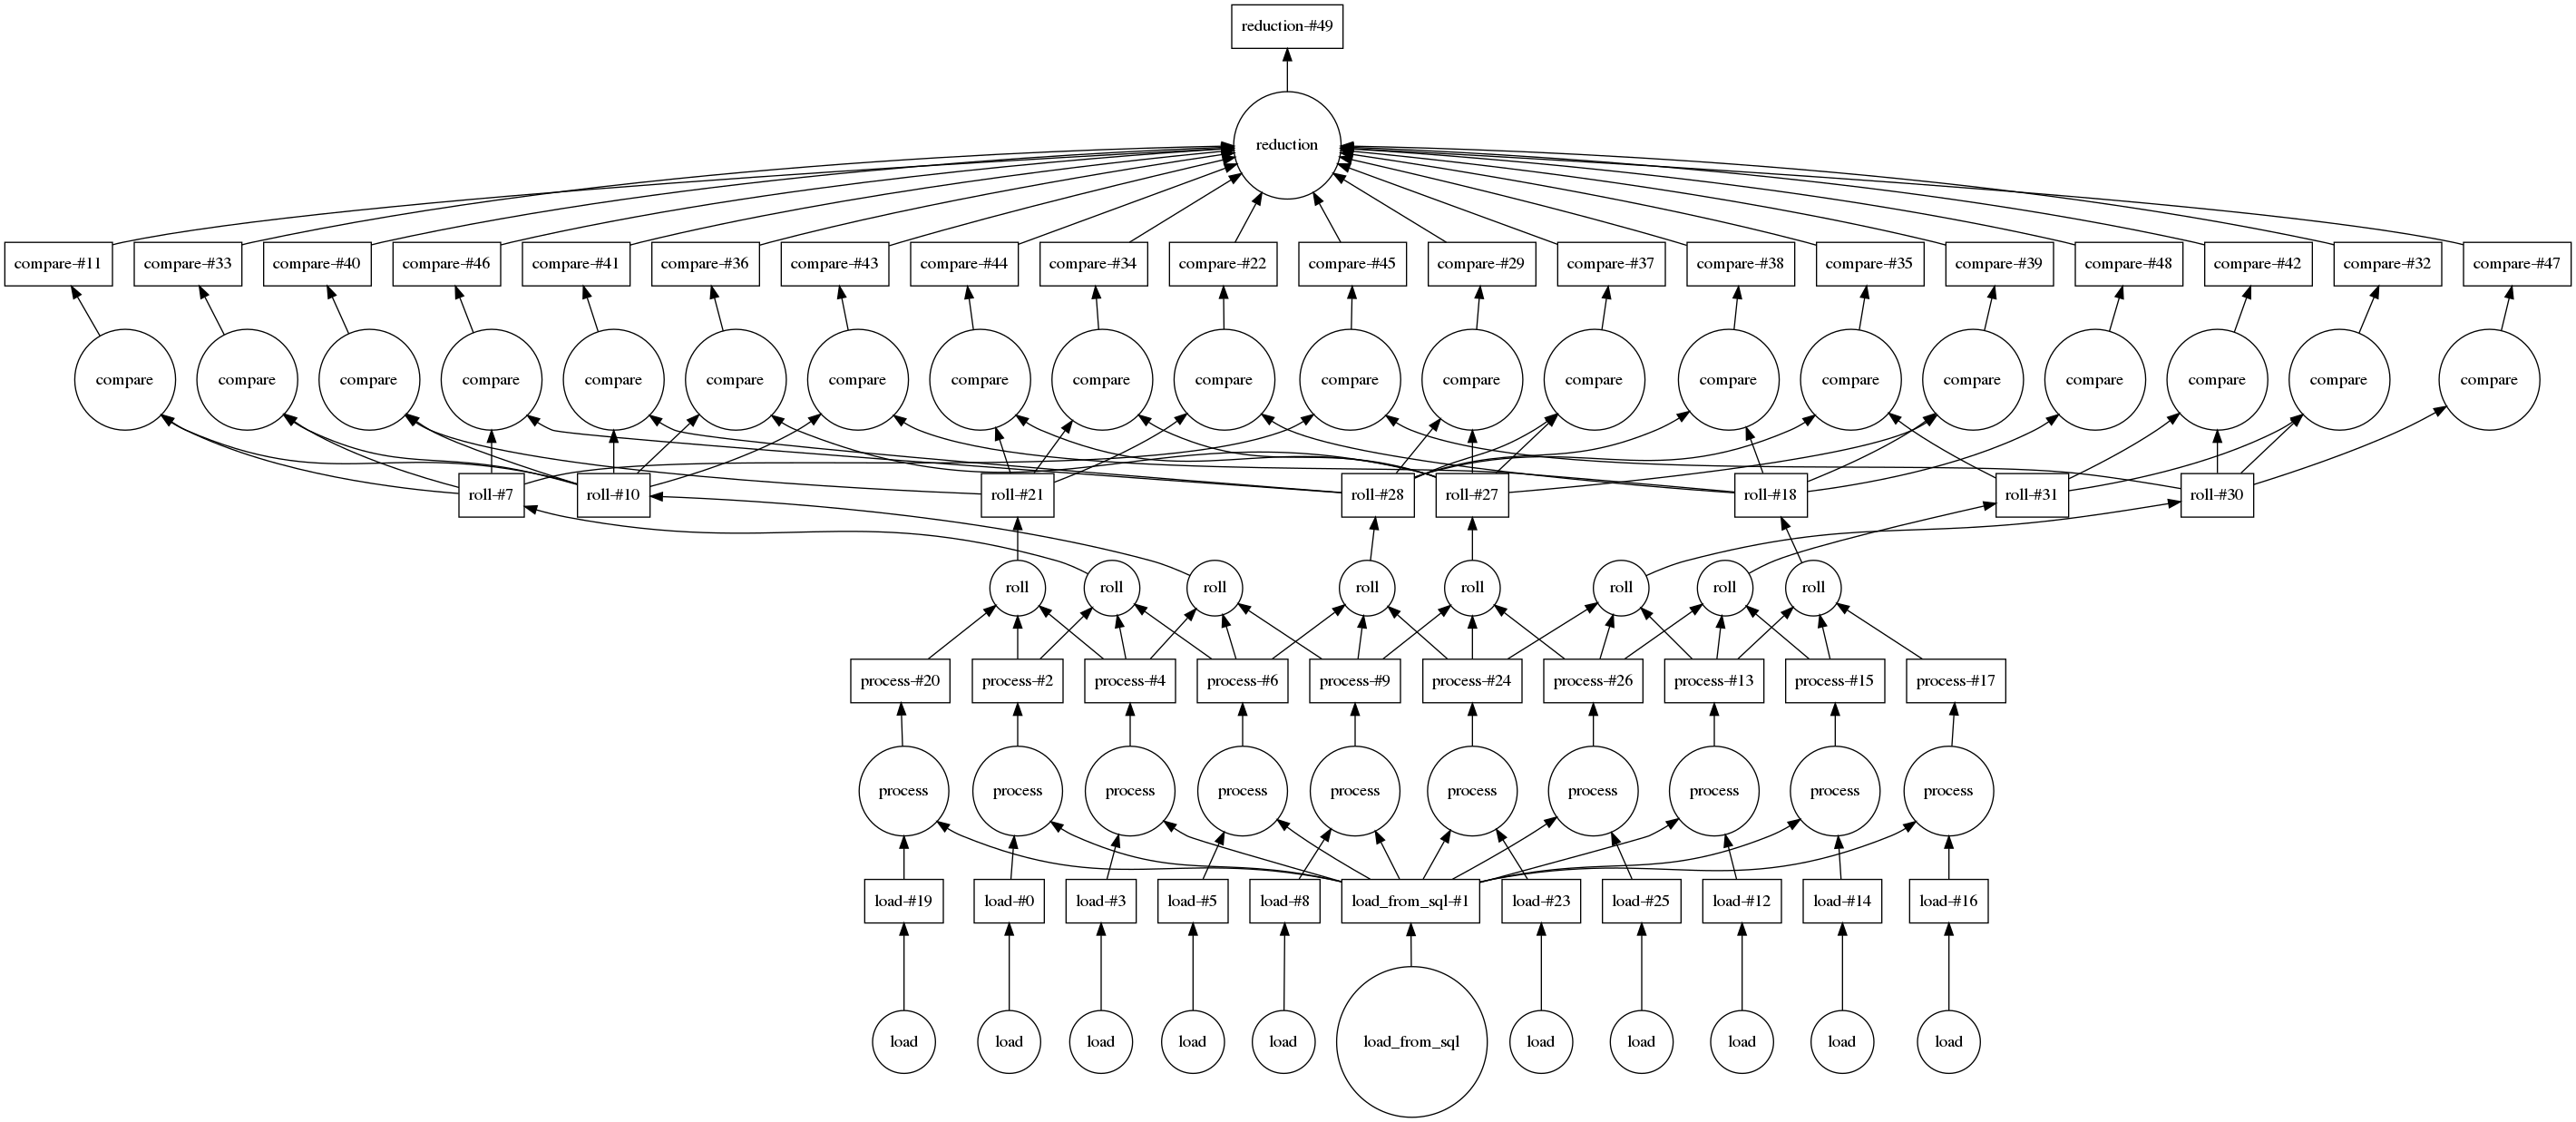

In [4]:
best.visualize()

We can connect to a small cluster with 20 cores

In [5]:
from distributed import Client

client = Client(n_workers=10)
client

Client Scheduler: tcp://127.0.0.1:37183 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 10 Cores: 10 Memory: 41.41 GB


We compute the result and see the trace of the computation running in real time.

In [6]:
result = best.compute()
result

In [7]:
client.close()

## Final Thoughts
Dask’s ability to write down arbitrary computational graphs Celery/Luigi/Airflow-style and yet run them with the scalability promises of Hadoop/Spark allows for a pleasant freedom to write comfortably and yet still compute scalably. This ability opens up new possibilities both to support more sophisticated algorithms and also to handle messy situations that arise in the real world (enterprise data systems are sometimes messy) while still remaining within the bounds of “normal and supported” Dask operation.